In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy.optimize import fsolve
from matplotlib import pyplot as plt

In [2]:
def calc_price(theta,cost,list_price,mu):
    """compute each insurer's price (assumes interior solution)"""
    theta1, theta2 = theta
    mu1, mu2 = mu
    p1 = (2.*theta1*mu1+theta2*mu2)/3. + cost
    p2 = (2.*theta2*mu2+theta1*mu1)/3. + cost
    return np.array([p1,p2])
  
    
def calc_t(theta,cost,list_price,mu):
    """compute the proportion of people choosing each insurer"""
    p1,p2 = calc_price(theta,cost,list_price,mu)
    t = (list_price - p1)/cost,(list_price - p2)/cost
    t = np.clip(t ,0,1) #ensure we are in the right ranges
    t_hat = .5 + (p2 - p1)/(2.*cost)
    t_hat = np.clip([t_hat,1-t_hat],0,1)
    if t[0] >= 1-t[1]: t = t_hat #prevent overlap
    return t


def calc_profits(theta,cost,list_price,mu):
    """compute profits for each firm"""
    p = calc_price(theta,cost,list_price,mu)
    t = calc_t(theta,cost,list_price,mu)
    return t*np.maximum(p-theta*mu,0)


def calc_hosp(theta,cost,list_price,mu):
    """compute profits for hospital"""
    t = calc_t(theta,cost,list_price,mu)
    return np.tile((mu*theta*t).sum(),2)

In [3]:
def outside_option(theta, cost,list_price,mu):
    """compute each firms outside option (i.e. list price)"""
    outside1 =  np.array((list_price,theta[1]))
    outside2 =  np.array((theta[0],list_price))
    
    no_deal1 = calc_profits(outside1,cost,list_price,mu)
    no_deal2 = calc_profits(outside2,cost,list_price,mu)

    return np.array([no_deal1[0], no_deal2[1]]) 


def nash_bargaining(theta,cost,list_price,beta,mu, no_deal=None):
    """compute the nash bargaining objective for both firms"""
    #print 'initial theta: %s'%theta
    theta = np.maximum(np.minimum(theta,list_price),0) #restrict 0 < theta < l
    profits = calc_profits(theta,cost,list_price,mu)
    hosp_profit = calc_hosp(theta,cost,list_price,mu)
    if np.amax([no_deal==None]): no_deal = outside_option(theta, cost,list_price,mu)
    return np.maximum(profits -  no_deal,0)**.5 *np.maximum(hosp_profit,0)**.5

In [4]:
def nash_in_nash(theta_init, theta_fixed, cost,list_price,beta,mu, no_deal):
    """solve the simultaneous objective, holding theta 2 fixed"""
    theta = np.concatenate([theta_init, [theta_fixed]])
    return -nash_bargaining(theta,cost,list_price,beta,mu, no_deal)[0]


def bargain_helper(theta_init, theta_fixed, cost,list_price,beta,mu):
    """solve each firm 1s optimization holding theta 2 fixed"""
    no_deal = outside_option([theta_fixed,theta_fixed],cost,list_price,mu)
    result = minimize(nash_in_nash, theta_init, args=(theta_fixed, cost,list_price,beta,mu,no_deal),
                      method='Nelder-Mead', options={'disp': False})
    return result.x


def simult_bargain(theta_init,cost,list_price,beta,mu):
    """solve the bargaining problems seperately and iterate for a solution"""       
    
    #loop variables
    theta = theta_init
    diff =  np.abs(np.max(theta - 0)) 
    
    maxiter = 10
    while maxiter >=0 and diff > 10e-7:
        #seems as though there is a contraction mapping here, need to think more about why
        theta_init = theta
        theta1 = bargain_helper(theta[0], theta[1], cost,list_price,beta,mu)
        theta2 = bargain_helper(theta[1], theta1[0], cost,list_price,beta[::-1],mu[::-1])
        #update loop variables
        theta = np.concatenate((theta1,theta2))
        diff = np.abs(np.max(theta - theta_init))
        maxiter = maxiter-1
        
    return np.concatenate((theta1, theta2))


In [5]:
def outside_seq(cost, list_price, beta, mu):
    """outside option for first mover"""
    outside_theta =  bargain_helper(list_price, list_price, cost, list_price, beta[::-1],mu[::-1])
    no_deal = calc_profits(np.array([list_price,outside_theta]),cost,list_price,mu)
    return no_deal


def seq_obj(theta_init, cost,list_price,beta,mu,no_deal):
    """ theta2 in the second stage """
    theta_fixed = bargain_helper(theta_init, theta_init[0], cost, list_price, beta[::-1],mu[::-1])
    return nash_in_nash(theta_init, theta_fixed[0], cost,list_price,beta,mu, no_deal)


def seq_bargain(theta_init,cost,list_price,beta,mu):
    """solve the bargaining problems seperately,
    then solve for the solution"""   
    #only compute no deal 1x for initial
    no_deal =  outside_seq(cost, list_price, beta, mu)
    result = minimize(seq_obj, theta_init[0], args=(cost,list_price,beta,mu, no_deal),
                      method='Nelder-Mead', options={'disp': False})
    theta1 = result.x
    theta2 = bargain_helper(theta_init[0], theta1[0], cost, list_price, beta[::-1],mu[::-1])
    return np.concatenate((theta1, theta2))

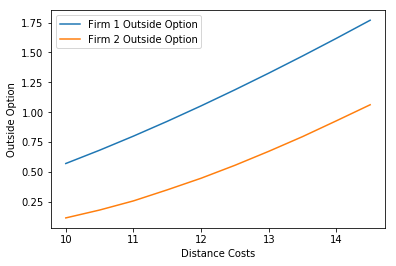

In [6]:
#Initialize some parameters

BETA = np.array([.5,.5])
MU = np.array([.5,.5])
THETA = np.array([.5, .5])
LIST = 1.
COST = 1.
lambdas = np.arange(10,15,.5)

#outside option for firm 1
outsides1 = [] 
for lamb in lambdas:
    o1 = outside_seq(lamb, 70, BETA, MU)
    outsides1.append(o1[0])
outsides1 = np.array(outsides1)
plt.plot(lambdas,outsides1, label='Firm 1 Outside Option')


#outside option for firm 2
outsides2 = [] 
for lamb in lambdas:
    theta1_outside = seq_bargain(np.array([10.0]),lamb,70.,BETA, MU)
    o2 = calc_profits(np.array([theta1_outside[0],70.0]),lamb,70., MU)
    outsides2.append(o2[1])
outsides2 = np.array(outsides2)
plt.plot(lambdas,outsides2, label='Firm 2 Outside Option')


plt.xlabel('Distance Costs')
plt.ylabel('Outside Option')
plt.legend()
plt.show()

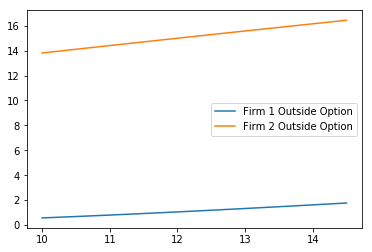

In [7]:
lambdas = np.arange(10,15,.5)
no_deals = []

for lamb in lambdas:
    outside_theta =  bargain_helper(70., 70., lamb, 70., BETA[::-1],MU[::-1])
    no_deal = calc_profits(np.array([70.,outside_theta]),lamb,70.,MU)
    no_deals.append(no_deal)

no_deals = np.array(no_deals)
plt.plot(lambdas, no_deals[:,0], label='Firm 1 Outside Option')
plt.plot(lambdas, no_deals[:,1], label='Firm 2 Outside Option')

plt.legend()
plt.show()

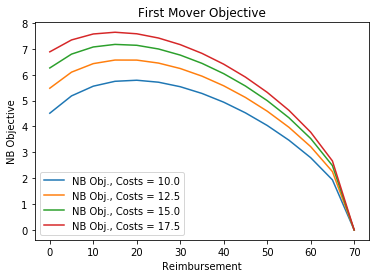

In [8]:
#graph first mover objective
thetas = np.arange(0,75,5)
lambdas = np.arange(10,20,2.5)
all_objs = []
for lamb in lambdas:
    objs = []
    for theta1 in thetas:
        no_deal =  outside_seq(lamb, 70, BETA,MU)
        obj_theta = -1*seq_obj([theta1], lamb,70, BETA,MU,no_deal)
        objs.append(obj_theta)
    objs = np.array(objs)
    all_objs.append(objs)
    plt.plot(thetas, objs, label='NB Obj., Costs = %s'%lamb)

plt.title('First Mover Objective')
plt.xlabel('Reimbursement')
plt.ylabel('NB Objective')
plt.legend()
plt.show()

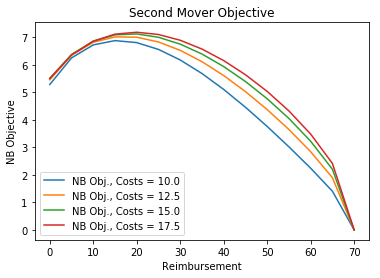

In [9]:
#graph second mover objective
thetas = np.arange(0,75,5)
lambdas = np.arange(10,20,2.5)
all_objs = []
for lamb in lambdas:
    objs = []
    theta1_outside = seq_bargain(np.array([10.0]),lamb,70.,BETA, MU)
    for theta1 in thetas:
        obj_theta = nash_bargaining([theta1, theta1_outside[0]],lamb,70.,BETA,MU)
        objs.append(obj_theta[0])
    objs = np.array(objs)
    all_objs.append(objs)
    plt.plot(thetas, objs, label='NB Obj., Costs = %s'%lamb)

plt.title('Second Mover Objective')
plt.xlabel('Reimbursement')
plt.ylabel('NB Objective')
plt.legend()
plt.show()

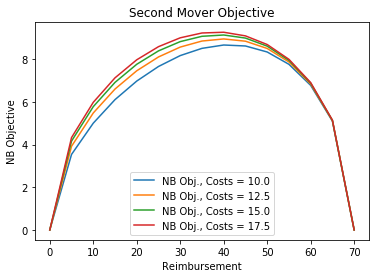

In [11]:
thetas = np.arange(0,75,5)
for lamb in lambdas:
    objs = []
    for theta1 in thetas:
        obj_theta = nash_bargaining([theta1, theta1],lamb,70.,BETA,MU)
        objs.append(obj_theta[0])
    objs = np.array(objs)
    all_objs.append(objs)
    plt.plot(thetas, objs, label='NB Obj., Costs = %s'%lamb)
    
    
plt.title('Second Mover Objective')
plt.xlabel('Reimbursement')
plt.ylabel('NB Objective')
plt.legend()
plt.show()